In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
import pandas as pd
from sklearn.model_selection import train_test_split

train_csv = "/content/drive/MyDrive/20news_train.csv"
test_csv = "/content/drive/MyDrive/20news_test.csv"

train_data = pd.read_csv(train_csv)
test_data = pd.read_csv(test_csv)

combined_data = pd.concat([train_data, test_data], ignore_index=True)

combined_data = combined_data.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"data number : {len(combined_data)}")


data number : 18846


In [2]:
!pip install --force-reinstall numpy==1.23.5 scipy==1.10.1 gensim==4.3.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 8.1 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: smart-open
    Found existing installation: smart-open 7.1.0
    Uninstalling smart-open-7.1.0:
      Successfully uninstalled smart-open-7.1.0
  Attempting uninstall: scipy
    Found existing installatio

!pip install gensim

In [60]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from gensim.utils import simple_preprocess

def load_glove_embeddings(glove_path):
    word_to_idx = {}
    embeddings = []
    with open(glove_path, 'r', encoding='utf8') as f:
        for idx, line in enumerate(f):
            parts = line.strip().split()
            word = parts[0]
            vec = np.array(parts[1:], dtype=np.float32)
            word_to_idx[word] = idx
            embeddings.append(vec)
    embedding_matrix = np.stack(embeddings)
    return word_to_idx, torch.FloatTensor(embedding_matrix)

glove_path = '/content/drive/MyDrive/glove.6B.100d.txt'
word_to_idx, glove_matrix = load_glove_embeddings(glove_path)
vocab_size, emb_dim = glove_matrix.shape
print(vocab_size, emb_dim) # 400000 words represented with 100 dimensions

400000 100


In [61]:
combined_data['split_label'] = combined_data['label'].str.split('.').str[0]

np.unique(combined_data["split_label"], return_counts=True)


(array(['alt', 'comp', 'misc', 'rec', 'sci', 'soc', 'talk'], dtype=object),
 array([ 799, 4891,  975, 3979, 3952,  997, 3253]))

In [62]:
num_classes = len(set(combined_data['split_label']))

# Tokenize each document using gensim's simple_preprocess
combined_data = combined_data.dropna(subset=['body'])
combined_data['tokenized_body'] = combined_data['body'].apply(lambda x: simple_preprocess(str(x)))


In [63]:
UNK_IDX = vocab_size # define unknown index

def doc2ind(tokens, word_to_idx, max_len):
    # Convert tokens to indices; if a token not in vocabulary, use UNK_IDX.
    idxs = [word_to_idx.get(token, UNK_IDX) for token in tokens]
    # pad with 0's if less than max_len
    if len(idxs) < max_len:
        idxs = idxs + [0] * (max_len - len(idxs))
    else:
        idxs = idxs[:max_len]
    return idxs

In [64]:
max_len = 50
docs_indices = [doc2ind(tokens, word_to_idx, max_len) for tokens in combined_data['tokenized_body']]

In [65]:
#make unknown vector for unknown words
unk_vector = torch.zeros(1, emb_dim)
glove_matrix = torch.cat([glove_matrix, unk_vector], dim=0)

In [66]:
from sklearn.preprocessing import LabelEncoder
import torch

label_encoder = LabelEncoder()
combined_data['split_label'] = label_encoder.fit_transform(combined_data['split_label'])

ng_labels = torch.LongTensor(combined_data['split_label'].values)
ng_vector_idx = torch.LongTensor(docs_indices)  # shape: (num_docs, max_len)

print(ng_labels)
print(ng_labels.shape)
print(type(ng_labels))

tensor([2, 6, 1,  ..., 6, 3, 1])
torch.Size([18817])
<class 'torch.Tensor'>


In [67]:
class NGDataset(Dataset):
    def __init__(self, vector_idx, labels):
        self.vector_idx = vector_idx
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.vector_idx[idx], self.labels[idx]

In [68]:
# Split the data into training and testing sets
train_idx, test_idx, train_labels, test_labels = train_test_split(
    ng_vector_idx, ng_labels, test_size=0.2, random_state=42
)

# Create datasets for training and testing
train_dataset = NGDataset(train_idx, train_labels)
test_dataset = NGDataset(test_idx, test_labels)

# Create data loaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [69]:
pre_glove_emb = nn.Embedding.from_pretrained(glove_matrix, freeze=True)

In [70]:
pre_glove_emb

Embedding(400001, 100)

In [72]:
class TextClassifier(nn.Module):
    def __init__(self, embedding, emb_dim, num_classes):
        super(TextClassifier, self).__init__()
        self.embedding = embedding
        self.fc = nn.Linear(emb_dim, num_classes)

    def forward(self, x):
        # x: (batch_size, max_len)
        emb = self.embedding(x)  # (batch_size, max_len, emb_dim)
        # mean pooling (batch_size, emb_dim)
        doc_emb = emb.mean(dim=1)
        logits = self.fc(doc_emb)  # (batch_size, num_classes)
        return logits

pre_model = TextClassifier(pre_glove_emb, emb_dim, num_classes)

In [73]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pre_model.parameters(), lr=0.001)

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

pre_model = pre_model.to(device)

num_epochs = 30
for epoch in range(num_epochs):
    pre_model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = pre_model(inputs)  # (batch_size, num_classes)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Training completed.")

Using device: cuda
Epoch [1/30], Loss: 0.8117
Epoch [2/30], Loss: 0.8103
Epoch [3/30], Loss: 0.8099
Epoch [4/30], Loss: 0.8079
Epoch [5/30], Loss: 0.8066
Epoch [6/30], Loss: 0.8059
Epoch [7/30], Loss: 0.8058
Epoch [8/30], Loss: 0.8041
Epoch [9/30], Loss: 0.8027
Epoch [10/30], Loss: 0.8019
Epoch [11/30], Loss: 0.8011
Epoch [12/30], Loss: 0.8002
Epoch [13/30], Loss: 0.7986
Epoch [14/30], Loss: 0.7988
Epoch [15/30], Loss: 0.7979
Epoch [16/30], Loss: 0.7964
Epoch [17/30], Loss: 0.7957
Epoch [18/30], Loss: 0.7947
Epoch [19/30], Loss: 0.7935
Epoch [20/30], Loss: 0.7943
Epoch [21/30], Loss: 0.7928
Epoch [22/30], Loss: 0.7923
Epoch [23/30], Loss: 0.7912
Epoch [24/30], Loss: 0.7909
Epoch [25/30], Loss: 0.7893
Epoch [26/30], Loss: 0.7900
Epoch [27/30], Loss: 0.7891
Epoch [28/30], Loss: 0.7878
Epoch [29/30], Loss: 0.7880
Epoch [30/30], Loss: 0.7869
Training completed.


In [75]:
pre_model.eval()
correct = 0
total = 0

pre_doc_embeddings = []  # To store document embeddings (one per test sample)
pre_all_labels = []      # To store corresponding labels

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Get word embeddings: shape (batch_size, seq_len, emb_dim)
        emb = pre_model.embedding(inputs)

        doc_emb = emb.mean(dim=1)
        pre_doc_embeddings.append(doc_emb.cpu().numpy())
        pre_all_labels.append(labels.cpu().numpy())

        outputs = pre_model(inputs)
        predictions = outputs.argmax(dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.7136


In [77]:
pre_doc_embeddings.shape

(3764, 100)

Visualization of pretrained glove embedding

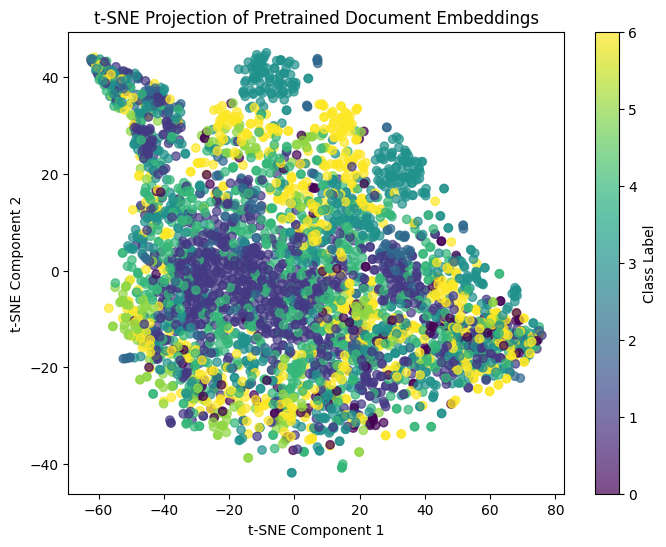

In [76]:
pre_doc_embeddings = np.vstack(pre_doc_embeddings)
pre_all_labels = np.concatenate([np.atleast_1d(label) for label in pre_all_labels], axis=0)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
pre_reduced_embeddings = tsne.fit_transform(pre_doc_embeddings)

plt.figure(figsize=(8,6))
scatter = plt.scatter(pre_reduced_embeddings[:, 0], pre_reduced_embeddings[:, 1],
                      c=pre_all_labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Class Label')
plt.title("t-SNE Projection of Pretrained Document Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

In [78]:
ft_glove_emb = nn.Embedding.from_pretrained(glove_matrix, freeze=False)
ft_model = TextClassifier(ft_glove_emb, emb_dim, num_classes).to(device)

In [80]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ft_model.parameters(), lr=1e-3)

In [81]:
num_epochs = 30
for epoch in range(num_epochs):
    ft_model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = ft_model(inputs)  # (batch_size, num_classes)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Training completed.")

Epoch [1/30], Loss: 1.5190
Epoch [2/30], Loss: 0.9933
Epoch [3/30], Loss: 0.6486
Epoch [4/30], Loss: 0.4462
Epoch [5/30], Loss: 0.3247
Epoch [6/30], Loss: 0.2460
Epoch [7/30], Loss: 0.1903
Epoch [8/30], Loss: 0.1496
Epoch [9/30], Loss: 0.1186
Epoch [10/30], Loss: 0.0943
Epoch [11/30], Loss: 0.0751
Epoch [12/30], Loss: 0.0607
Epoch [13/30], Loss: 0.0486
Epoch [14/30], Loss: 0.0393
Epoch [15/30], Loss: 0.0325
Epoch [16/30], Loss: 0.0267
Epoch [17/30], Loss: 0.0224
Epoch [18/30], Loss: 0.0187
Epoch [19/30], Loss: 0.0158
Epoch [20/30], Loss: 0.0136
Epoch [21/30], Loss: 0.0119
Epoch [22/30], Loss: 0.0104
Epoch [23/30], Loss: 0.0091
Epoch [24/30], Loss: 0.0081
Epoch [25/30], Loss: 0.0071
Epoch [26/30], Loss: 0.0063
Epoch [27/30], Loss: 0.0058
Epoch [28/30], Loss: 0.0053
Epoch [29/30], Loss: 0.0048
Epoch [30/30], Loss: 0.0044
Training completed.


In [82]:
ft_model.eval()
correct = 0
total = 0

ft_doc_embeddings = []
ft_all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        emb = ft_model.embedding(inputs)

        doc_emb = emb.mean(dim=1)
        ft_doc_embeddings.append(doc_emb.cpu().numpy())
        ft_all_labels.append(labels.cpu().numpy())

        outputs = ft_model(inputs)
        predictions = outputs.argmax(dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9028


Finetuned embedding visualization

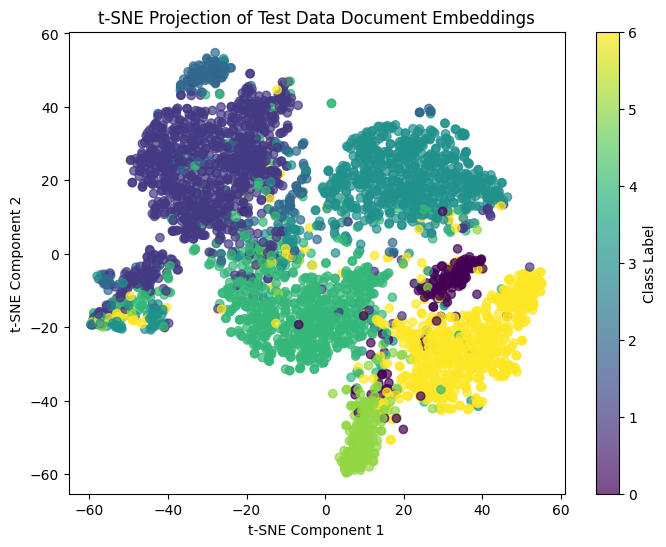

In [35]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

doc_embeddings = np.concatenate(ft_doc_embeddings, axis=0)
all_labels = [np.atleast_1d(label) for label in ft_all_labels]
all_labels = np.concatenate(ft_all_labels, axis=0)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
reduced_embeddings = tsne.fit_transform(doc_embeddings)

plt.figure(figsize=(8,6))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1],
                      c=all_labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Class Label')
plt.title("t-SNE Projection of Test Data Document Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()